### Установка пакетов

Начнем с установки необходимых пакетов python. Ничего необычного не понадобится - numpy, cv2, matplotlib.

In [1]:
# !pip install numpy
# !pip install opencv-python
# !pip install matplotlib

Теперь можно импортировать

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from  random import randint
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

### Инициализация SLAM с использованием OpenCV

Итак, мы снова находимся в сгенерированном мире c первой лекции. У нас был автомобиль, на котором были установлены сенсоры, выдающие нам карту глубин вместе с картинкой, а так же трансформацию (позу) в каждый момент времени. Теперь перейдем к более реальной ситуации: на нашей машине установлена только камера и ничего более (очень часто решается именно такая задача). Будем восстанавливать позу и глубины точек при помощи знаний, полученных на лекции (восстановление первой позы иногда называют инициализацией). Начнем с восстановления позы.

Вам даны два изображения, вращение и перемещение между которыми мы хотим определить.

In [3]:
def load_image(path: str) -> np.ndarray:
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

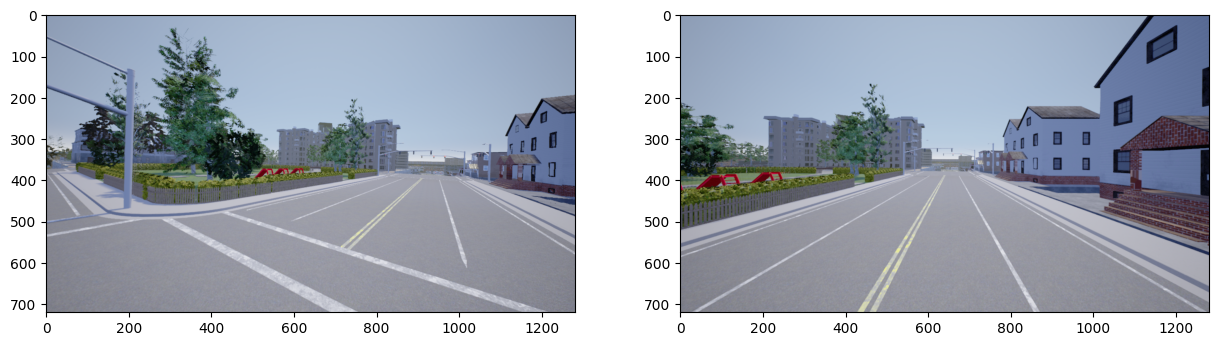

In [4]:
image1 = load_image("image1.png")
image2 = load_image("image2.png")
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image1)
axarr[1].imshow(image2)
plt.show()

Как мы узнали на лекции, первое, что нужно сделать для восстановления позы - найти особые точки (фичи) на обоих изображениях и соответствие между ними (сматчить). Ранее вы уже научились это делать, поэтому не будем сильно заострять на этом внимание: найдите фичи и матчи любым способом, который вам понравился ([здесь](https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html) можете найти пример с SIFT фичами).

In [5]:
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(image1, None)
kp2, des2 = sift.detectAndCompute(image2, None)

bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.knnMatch(des1, des2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

pts1 = np.array([kp1[m.queryIdx].pt for m in good_matches], dtype=np.float64)
pts2 = np.array([kp2[m.trainIdx].pt for m in good_matches], dtype=np.float64)

Визуализируем наши матчи.

In [6]:
def draw_matches(image_a: np.ndarray, image_b: np.ndarray, keypoints_a: np.ndarray, keypoints_b: np.ndarray):
    # initialize the output visualization image
    height_a, width_a = image_a.shape[:2]
    height_b, width_b = image_b.shape[:2]

    vis = np.zeros((max(height_a, height_b), width_a + width_b, 3), dtype="uint8")
    vis[0:height_a, 0:width_a] = image_a
    vis[0:height_b, width_a:] = image_b

    # loop over the matches
    for keypoint_a, keypoint_b in zip(keypoints_a, keypoints_b):
        # draw the match
        point_a = (int(keypoint_a[0]), int(keypoint_a[1]))
        point_b = (
            int(keypoint_b[0]) + width_a,
            int(keypoint_b[1]),
        )
        cv2.line(vis,
                 point_a,
                 point_b,
                 (randint(0, 255), randint(0, 255), randint(0, 255)), 1)

    # return the visualization
    return vis

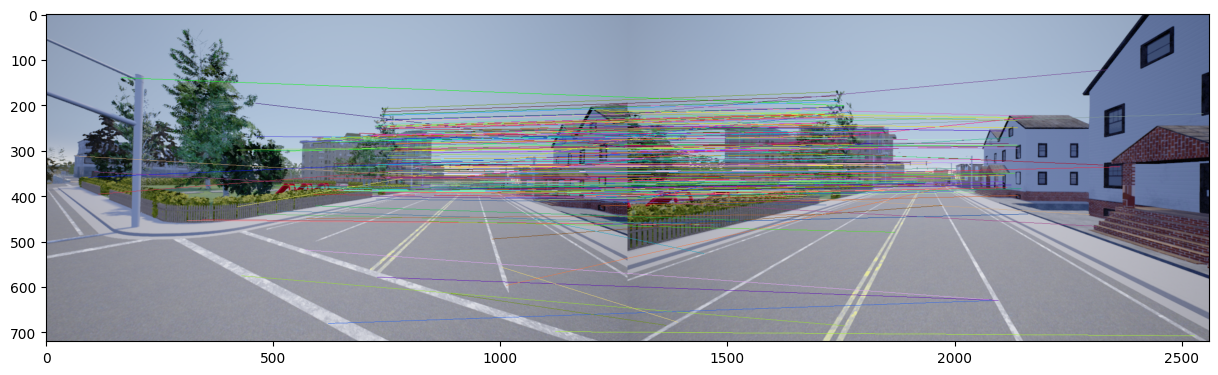

(<matplotlib.image.AxesImage at 0x2474a800e10>, None)

In [7]:
img3 = draw_matches(image1, image2, pts1, pts2)
plt.imshow(img3),plt.show()

Итак, у нас есть матчи. Начнем с простого - воспользуемся встроенной функцией в OpenCV для определения существенной матрицы. Смотрите референс [здесь](https://amroamroamro.github.io/mexopencv/matlab/cv.findEssentialMat.html). Вам нужно правильно определить матрицу камеры и передать точки с левого и правого изображения.

In [8]:
fx = 448.1551643293023
fy = 448.1551643293023
px = 640.0
py = 360.0

K = np.array([
    [fx,  0, px],
    [ 0, fy, py],
    [ 0,  0,  1]
], dtype=np.float64)

E, mask = cv2.findEssentialMat(
    pts1,
    pts2,
    K,
    method=cv2.RANSAC,
    prob=0.999,
    threshold=1.0
)

Отлично, у нас есть существенная матрица E, а также некторая маска mask. Это маска показывает, какие из матчей у нас соответствуют полученной матрице (inliers), а какие нет (outliers).

In [9]:
mask = mask.ravel().astype(bool)

pts1_inliers = pts1[mask]
pts2_inliers = pts2[mask]

Визуализируем инлайеры и посмотрим, какой процент точек оказался инлайерами. Чем процент больше, тем лучше был наш матчер. Нормально, если он будет около 50%.

Процент инлайеров: 61.73913043478261%


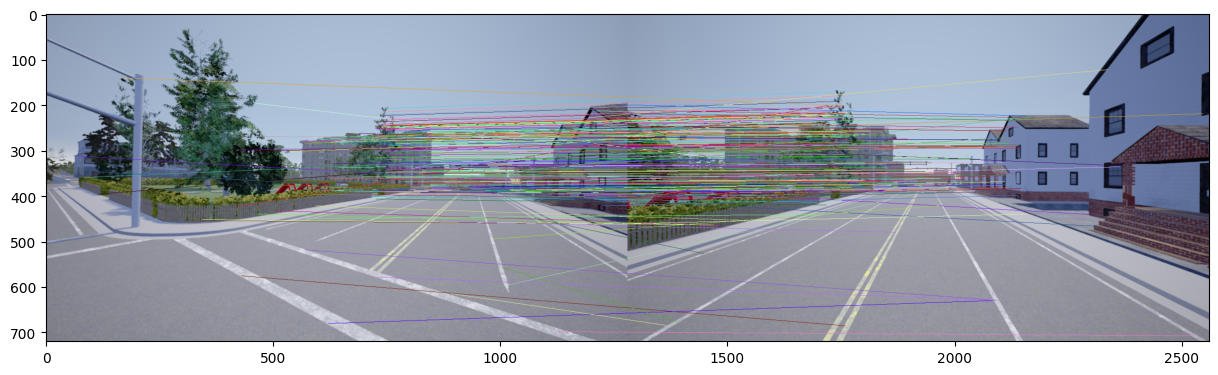

(<matplotlib.image.AxesImage at 0x2474b5de110>, None)

In [10]:
print(f"Процент инлайеров: {pts1_inliers.shape[0] / pts1.shape[0] * 100}%")

img3 = draw_matches(image1, image2, pts1, pts2)
plt.imshow(img3),plt.show()

Если визуально корреспонденсы между изображениями выглядят адекватно, то самое время восстанавливать позу из существенной матрицы. Сейчас воспользуемся для этого внутренней функцией OpenCV - recoverPose. Не забудьте использовать для это только инлайеры!

In [11]:
numOfInliers, R_opencv, t_opencv, mask = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)

Отлично, у нас есть оцененные R и t. Самое время сравнить его с ground truth (gt), который нам был дан в 3 лабораторной. Есть один нюанс: на лекции мы узнали, что из алгоритмов такого рода нельзя восстановить скейл сцены, поэтому перед сравнением t_gt нужно нормализовать.

In [12]:
R_gt = np.array([[8.50318515e-01, 2.07742095e-02, -5.25858208e-01],
              [-2.47312245e-02, 9.99694013e-01, -4.97406376e-04],
              [5.25686969e-01, 1.34280713e-02, 8.50572100e-01]])
t_gt = np.array([[6.51715996e-01, 6.20712517e-03, -6.44666629e+00]]).transpose()
scale = np.linalg.norm(t_gt)
t_gt /= scale

print(f"Ошибка в матрице вращения: {np.linalg.norm(R_gt - R_opencv) / np.linalg.norm(R_gt) * 100}%")
print(f"Ошибка в перемещении: {np.linalg.norm(t_gt - t_opencv) / np.linalg.norm(t_gt) * 100}%")

Ошибка в матрице вращения: 1.101079473113367%
Ошибка в перемещении: 9.718801111895342%


Ошибиться на 1% во вращении и на 3% в перемещении - это нормально, хороший результат.

И последний этап с использованием готовых функций: восстановим глубины фич. Для этого нужно воспользоваться функцией triangulatePoints из библиотеки OpenCV. У нее чуть более хитрые входные данные, составим их поэтапно. Подумайте над тем, какую именно позу мы нашли (R_opencv, t_opencv), и какие позы у первого и второго изображения.

In [13]:
projection_matrix_1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))

projection_matrix_2 = K @ np.hstack((R_opencv, t_opencv))

points_3d_hom = cv2.triangulatePoints(
    projection_matrix_1,
    projection_matrix_2,
    pts1_inliers.T,
    pts2_inliers.T
)

points_3d = (points_3d_hom[:3] / points_3d_hom[3]).T

depth_opencv = points_3d[:, 2]


Самое время загрузить глубины, которые были даны в 3 лабораторной работе, и сравнить с полученными. Опять же, не забудьте, что глубины точек метрические, а значит, зависят от скейла. Мы уже зафиксировали скейл для gt, поэтому воспользуемся им.

In [14]:
# Загрузим gt глубины, нормируем их
depth_gt_full = np.load("depth1.npy") * 1000 / scale
# Выделим gt глубины только для фич
depth_gt = depth_gt_full[pts1_inliers[:, 1].astype(int), pts1_inliers[:, 0].astype(int)].squeeze()

# Посчитаем среднюю ошибку. Не будем учитывать слишком далекие точки
errors = []
for i, d_gt in enumerate(depth_gt):
    if d_gt < 100 / scale:
        print(d_gt, depth_opencv[i])
        errors.append(abs(d_gt - depth_opencv[i]) / max(d_gt, depth_opencv[i]) * 100)

print(f"Средняя ошибка в определении глубин: {sum(errors) / len(errors)}%")

8.8010845 7.725996290707375
9.878619 9.128248303860767
3.108324 5.966018412128414
6.847197 6.744894909034997
6.5166616 6.474464710824227
4.57959 5.0130723628151355
6.525695 6.430838742416961
5.193572 4.958841810772923
6.510112 6.70568374906349
6.7988386 6.646915106226756
6.805094 6.873730279178923
7.679662 5.633752661439382
7.051008 6.991149277569255
7.051008 6.991149277569255
5.43095 5.714191085613549
6.8276954 6.852361030656491
5.3856454 5.635742698250552
7.052922 6.950430896988646
6.8958874 6.7225143149091116
6.8958874 6.7225143149091116
6.8176317 6.811956087911513
6.8294983 6.812421846228017
7.1436048 6.902336008825248
6.720307 6.894671061276081
6.720307 6.894671061276081
6.918185 6.982373024891347
13.77288 6.872470487508505
6.8350916 6.8915535447520435
6.8662663 6.806224900146737
7.0554237 7.01842993061106
7.0613847 6.928548248852811
7.039307 6.953243978708574
7.039307 6.953243978708574
6.7780123 6.669753126520468
7.0606213 6.896087668362795
6.8720984 6.814571243116009
7.0700684 7

Отлично, ошибиться на 10% в определении глубин - это нормально, на это влияет много факторов.

Итак, мы проделали полную инициализацию SLAM - нашли матчи, посчитали существенную матрицу, восстановили позу и глубины.